# Voice Recognition with Deep Learning

In [1]:
# Data manipulation
import pandas as pd 
import numpy as np 

# For preprocessing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

## Plotting data
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import os
from pathlib import Path
# set current working dir
os.chdir(Path('/home/adriel_martins/Documents/voice_recognition'))

## Reading Data

Our initial data comes from the numpy array that we made with the 'Signal_Feature_Extraction' notebook.

In [2]:
# The next code loads the saved numpy array of our extracted features
# The first 5 components are features, and the last one is the label.
features_label = np.load(Path('Data/features_label.npy'), allow_pickle=True)
features_label[0]

(array([-3.81585693e+02,  6.90094528e+01, -2.08241310e+01,  5.36909370e+01,
        -4.27509212e+00,  2.32051907e+01, -5.91666079e+00, -2.85503268e+00,
         5.86745679e-01, -1.01091135e+00,  8.19765210e-01, -6.41121006e+00,
         5.29858685e+00, -6.15453434e+00,  5.54958105e+00, -2.27668762e-01,
        -3.26633596e+00,  1.09925546e-01, -7.21926868e-01, -1.97017848e+00,
        -4.42873621e+00,  1.75762415e+00, -3.47852039e+00, -2.22059995e-01,
         6.70306444e-01,  3.93470824e-01, -1.39223528e+00, -4.82977241e-01,
        -1.04150867e+00, -2.57553458e+00,  7.87113309e-01, -3.07437825e+00,
        -8.10151219e-01, -1.33137190e+00,  3.76484692e-01,  9.09384668e-01,
        -6.73609972e-01,  1.10683501e+00, -5.20829950e-03,  6.58193231e-01],
       dtype=float32),
 array([0.5965773 , 0.63604   , 0.6442102 , 0.62456167, 0.6260196 ,
        0.6399577 , 0.5416663 , 0.5729049 , 0.63341737, 0.6831666 ,
        0.6876952 , 0.6031007 ], dtype=float32),
 array([7.78472245e-01, 1.08756

In [3]:
# Creating our numpy arrays
features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))
labels = []
for i in range(0, len(features_label)):
    labels.append(np.array(features_label[i][5]))
                
X = np.array(features)
y = np.array(labels)

##  Preparing data: Hot Enconding and Pre-processing

In [4]:
print(y[0])
y = LabelEncoder().fit_transform(y)
print(y[0])

8629
96


In [5]:
# Splitting between validation and training and testing
X_train = X[:400]
Y_train = y[:400]

X_validation = X[400:450]
Y_validation = y[400:450]

X_test = X[450:501]
Y_test = y[450:501]

In [6]:
ss = StandardScaler()

X_train = torch.FloatTensor(ss.fit_transform(X_train))
Y_train = torch.LongTensor(Y_train)

X_test = torch.FloatTensor(ss.fit_transform(X_test))
Y_test = torch.LongTensor(Y_test)

X_validation = torch.FloatTensor(ss.fit_transform(X_validation))
Y_validation = torch.LongTensor(Y_validation)

In [7]:
Y_train.size()

torch.Size([400])

In [8]:
class Classifier(nn.Module):
    def __init__(self, input_feat, output_feat):
        super().__init__()
        self.fc1 = nn.Linear(input_feat, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 100)
        self.fc4 = nn.Linear(100, output_feat)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=0)
        
        return x

model = Classifier(input_feat=X_train.size()[1], output_feat=100)
model

Classifier(
  (fc1): Linear(in_features=193, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
)

In [9]:
model = Classifier(input_feat=X_train.size()[1], output_feat=100)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# number of epochs to train the model
n_epochs = 100

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to +infinity

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    print(epoch)
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    lower_bound_index = 0
    for upper_bound_index in range(1,11):
    
        index_range = range(lower_bound_index,
                            (upper_bound_index*(len(X_train)//10)))

        lower_bound_index = upper_bound_index

        x = X_train[index_range]
        y = Y_train[index_range]

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(x) # log_ps
        # calculate the loss
        loss = criterion(output, y)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*X_train.size(0)

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    lower_bound_index = 0
    for upper_bound_index in range(1,11):
    
        index_range = range(lower_bound_index,
                            (upper_bound_index*(len(X_validation)//10)))

        lower_bound_index = upper_bound_index

        x = X_validation[index_range]
        y = Y_validation[index_range]

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(x) # log_ps
        # calculate the loss
        loss = criterion(output, y) 
        # update running validation loss 
        valid_loss += loss.item()*X_validation.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(X_train)
    train_losses.append(train_loss)
    valid_loss = valid_loss/len(X_validation)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

0
Epoch: 1 	Training Loss: 51.345001 	Validation Loss: 28.858263
Validation loss decreased (inf --> 28.858263).  Saving model ...
1
Epoch: 2 	Training Loss: 48.825115 	Validation Loss: 26.061007
Validation loss decreased (28.858263 --> 26.061007).  Saving model ...
2
Epoch: 3 	Training Loss: 41.854715 	Validation Loss: 19.910911
Validation loss decreased (26.061007 --> 19.910911).  Saving model ...
3
Epoch: 4 	Training Loss: 30.665243 	Validation Loss: 12.698978
Validation loss decreased (19.910911 --> 12.698978).  Saving model ...
4
Epoch: 5 	Training Loss: 21.031508 	Validation Loss: 8.115187
Validation loss decreased (12.698978 --> 8.115187).  Saving model ...
5
Epoch: 6 	Training Loss: 14.910776 	Validation Loss: 5.228189
Validation loss decreased (8.115187 --> 5.228189).  Saving model ...
6
Epoch: 7 	Training Loss: 11.971275 	Validation Loss: 3.562073
Validation loss decreased (5.228189 --> 3.562073).  Saving model ...
7
Epoch: 8 	Training Loss: 10.655979 	Validation Loss: 2.93564

In [10]:
model = Classifier(X_train.size()[1], 100)
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [11]:
# initialize lists to monitor test loss and accuracy
test_loss = 0
accuracy = 0
test_losses = []

model.eval() # prepare model for evaluation
# To speed up calculations, forget the gradients, etc.
with torch.no_grad():
    lower_bound_index = 0
    for upper_bound_index in range(1,11):
    
        index_range = range(lower_bound_index,
                            (upper_bound_index*(len(X_validation)//10)))

        lower_bound_index = upper_bound_index

        x = X_test[index_range]
        y = Y_test[index_range]
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(x) # log_ps
        # calculate the loss
        loss = criterion(output, y)
        # update test loss 
        test_loss += loss.item()*x.size(0)
        test_losses.append(test_loss)

        ps = torch.exp(output) # cuz our model outputs log-probability
        top_p, top_class = ps.topk(1, dim = 1)
        
        equals = (top_class == y.view(*top_class.shape))
        accuracy += torch.mean(equals.type(torch.FloatTensor))/(len(range(1,11)))

        print("Test Loss: {:.3f}.. ".format(test_loss/len(X_test)),
              "Test Accuracy: {:.3f}".format(accuracy))

Test Loss: 0.003..  Test Accuracy: 0.040
Test Loss: 0.004..  Test Accuracy: 0.118
Test Loss: 0.100..  Test Accuracy: 0.179
Test Loss: 0.223..  Test Accuracy: 0.238
Test Loss: 0.447..  Test Accuracy: 0.305
Test Loss: 0.709..  Test Accuracy: 0.369
Test Loss: 1.083..  Test Accuracy: 0.438
Test Loss: 1.412..  Test Accuracy: 0.510
Test Loss: 1.911..  Test Accuracy: 0.589
Test Loss: 2.495..  Test Accuracy: 0.667


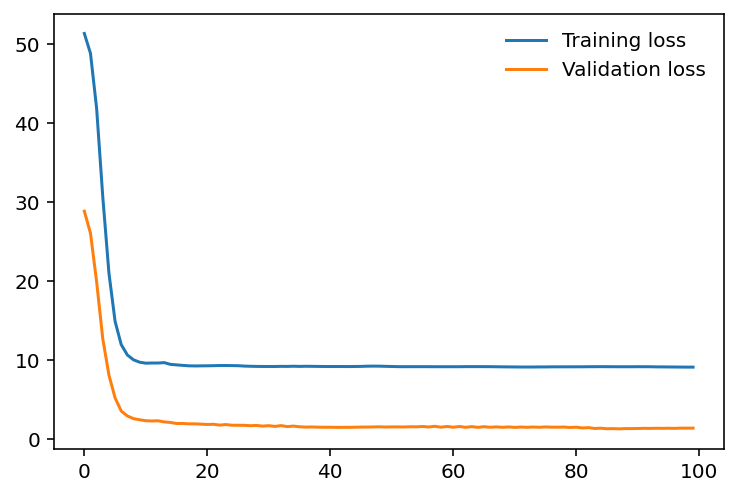

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)